In [1]:
import sys
sys.path.append("../../src/")
from mfmodeling import NARGP
help(NARGP)

Help on class NARGP in module mfmodeling.NARGP_GPy:

class NARGP(builtins.object)
 |  NARGP(*args, **kwargs)
 |  
 |  Nonlinear autoregressive multi-fidelity Gaussian process regression (NARGP)
 |  P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
 |  Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Parameters
 |      ----------
 |      data_list : list[nfidelity]
 |          List of multi-fidelity training data of y=f(x), where input x and output y are vectors.
 |          
 |          Structure of the list of data is as follow.
 |          data_list[ 0] = [data_input_lowest[nsample_lowest,ninput],   data_output_lowest[nsample_lowest,noutput_lowest]]
 |          data_list[ 1] = [data_input_1st[nsample_1st,ninput],         data_output_1st[nsample_1st,noutput_1st]]
 |          ...
 |          data_list[-1] = [data_input_h

### Preparation of data set

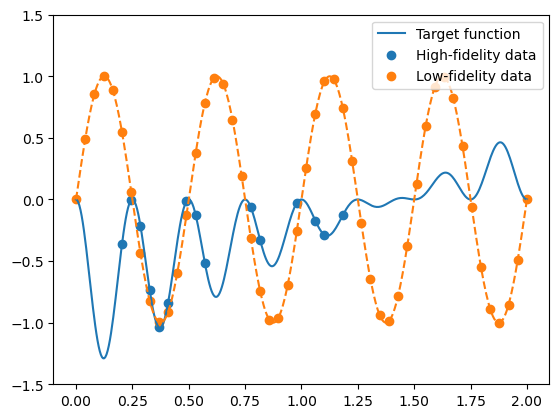

(50, 1) (50, 1) (2, 50, 1)


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(24)

''' function definitions '''
def high(x):
    return (x-np.sqrt(2))*low(x)**2
    # return low(x)**2

def low(x):
    return np.sin(4.0*np.pi*x)

''' Define training and test points '''
dim = 1
s = 2
plot = 1
N1 = 50
N2 = np.array([15])

Nts = 400
Xtest = np.linspace(0,2, Nts)[:,None]
Exact= high(Xtest)
Low = low(Xtest)

X1 = np.linspace(0,2, N1)[:,None]
# perm = np.random.permutation(N1)
perm = np.random.permutation(int(N1*0.6))
X2 = X1[perm[0:N2[0]]]

Y1 = low(X1)
Y2 = high(X2)

plt.plot(Xtest,Exact,label="Target function")
plt.plot(Xtest,Low,"--")
plt.scatter(X2,Y2,label="High-fidelity data")
plt.scatter(X1,Y1,label="Low-fidelity data")
plt.legend()
plt.ylim(-1.5,1.5)
plt.show()

In [8]:
data_list = [[X1,Y1], # Low-fidelity data set
             [X2,Y2]] # High-fidelity data set
model_nargp = NARGP(data_list=data_list)
model_nargp.optimize()
mean, var = model_nargp.predict(Xtest)

reconstraining parameters GP_regression.Gaussian_noise.variance


nfidelity= 2 , optimize_restarts= 30 , max_iters= 400
Optimization restart 1/30, f = -235.71270250206223
Optimization restart 2/30, f = 53.11318103282612
Optimization restart 3/30, f = 53.113188088201
Optimization restart 4/30, f = -235.7126737098579
Optimization restart 5/30, f = 53.11318220756276
Optimization restart 6/30, f = -235.71270319888086
Optimization restart 7/30, f = 53.11318201892546
Optimization restart 8/30, f = 53.113184651334194
Optimization restart 9/30, f = 53.11317955117197
Optimization restart 10/30, f = -235.71271647530065
Optimization restart 11/30, f = 53.11317957288477
Optimization restart 12/30, f = 53.113181665613304
Optimization restart 13/30, f = -235.7126517110511
Optimization restart 14/30, f = 53.11319969769069
Optimization restart 15/30, f = 53.11318744106727
Optimization restart 16/30, f = 53.11317965028765
Optimization restart 17/30, f = 53.1131804794653
Optimization restart 18/30, f = -235.71270716984046


 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/smae/.local/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 19/30, f = -235.71270473203836
Optimization restart 20/30, f = 53.113204117434734
Optimization restart 21/30, f = -235.71236041255295
Optimization restart 22/30, f = 53.113179463297016
Optimization restart 23/30, f = 53.11317954120791
Optimization restart 24/30, f = 53.11318720984569
Optimization restart 25/30, f = -235.7126928192802


reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 26/30, f = -235.71270277409096
Optimization restart 27/30, f = -235.71270548738673
Optimization restart 28/30, f = 53.11317952653467
Optimization restart 29/30, f = 53.113179641059546
Optimization restart 30/30, f = 53.11318474207272
Optimization restart 1/30, f = -16.56144545870906
Optimization restart 2/30, f = -16.56144554191559
Optimization restart 3/30, f = -16.561445549757195
Optimization restart 4/30, f = -16.561445523487556
Optimization restart 5/30, f = -16.561445548428807
Optimization restart 6/30, f = -16.561445552239846
Optimization restart 7/30, f = -16.56144548325757
Optimization restart 8/30, f = -16.561445503975946
Optimization restart 9/30, f = -16.561445511597277
Optimization restart 10/30, f = -16.56144548128664
Optimization restart 11/30, f = -16.561445528214804
Optimization restart 12/30, f = -16.56144554503942
Optimization restart 13/30, f = -15.845664327453822
Optimization restart 14/30, f = -16.56144551939687
Optimization restart 15/30, f = 

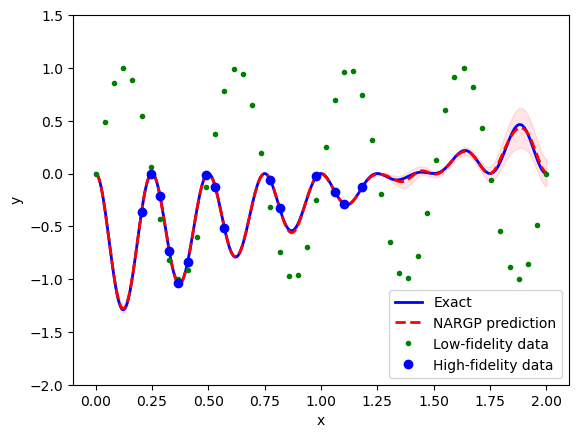

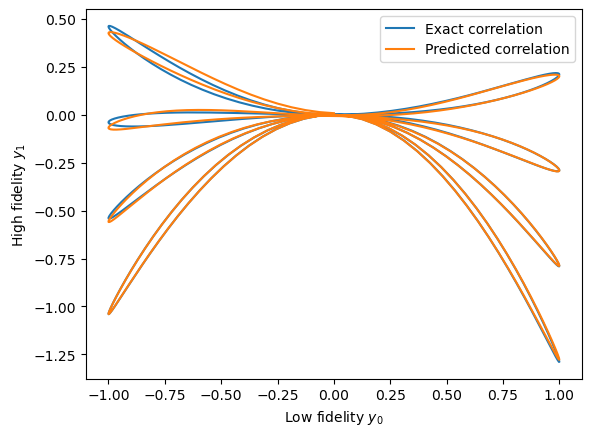

In [23]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Xtest, Exact, 'b', label='Exact', linewidth = 2)
ax.plot(Xtest, mean, 'r--', label = 'NARGP prediction', linewidth = 2)
ax.fill_between(Xtest.ravel(), (mean-2.0*np.sqrt(var)).ravel(), (mean+2.0*np.sqrt(var)).ravel(), alpha=0.1, color='red')
ax.plot(X1, Y1,'g.', label="Low-fidelity data")
ax.plot(X2, Y2,'bo', label="High-fidelity data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(-2,1.5)
ax.legend()
plt.show()

mean0, var0 = model_nargp.predict(Xtest,ifidelity=0)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Low, Exact, label = "Exact correlation")
ax.plot(mean0, mean, label = "Predicted correlation")
ax.set_xlabel(r"Low fidelity $y_0$")
ax.set_ylabel(r"High fidelity $y_1$")
ax.legend()
plt.show()

In [17]:
from mfmodeling import SingleGP
data = [X2,Y2] # Single GP using only high-fidelity data
model_singlegp = SingleGP(data = data)
model_singlegp.optimize()
mean_singlegp, var_singlegp = model_singlegp.predict(Xtest)

reconstraining parameters GP_regression.Gaussian_noise.variance


optimize_restarts= 30 , max_iters= 400
Optimization restart 1/30, f = -0.8727502325484027
Optimization restart 2/30, f = 5.409026827780613
Optimization restart 3/30, f = 5.409026827782496
Optimization restart 4/30, f = 5.409026827784766
Optimization restart 5/30, f = 5.409026827784247
Optimization restart 6/30, f = 5.409026827782911
Optimization restart 7/30, f = 5.409026827781809
Optimization restart 8/30, f = 5.409026827781285
Optimization restart 9/30, f = 5.40902682820606
Optimization restart 10/30, f = 5.409026828222312
Optimization restart 11/30, f = 5.4090268280188525
Optimization restart 12/30, f = 5.409026827811888
Optimization restart 13/30, f = 5.409026827781473
Optimization restart 14/30, f = 5.409026827782888
Optimization restart 15/30, f = 5.409026827781853
Optimization restart 16/30, f = 5.409026827799362
Optimization restart 17/30, f = 5.40902682778324
Optimization restart 18/30, f = 5.40902682778346
Optimization restart 19/30, f = 5.409026827823376
Optimization restart

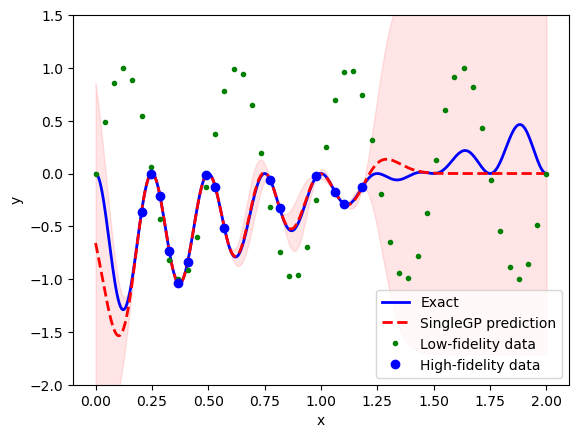

In [22]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Xtest, Exact, 'b', label='Exact', linewidth = 2)
ax.plot(Xtest, mean_singlegp, 'r--', label = 'SingleGP prediction', linewidth = 2)
ax.fill_between(Xtest.ravel(), (mean_singlegp-2.0*np.sqrt(var_singlegp)).ravel(), (mean_singlegp+2.0*np.sqrt(var_singlegp)).ravel(), alpha=0.1, color='red')
ax.plot(X1, Y1,'g.', label="Low-fidelity data")
ax.plot(X2, Y2,'bo', label="High-fidelity data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(-2,1.5)
ax.legend()
plt.show()